In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import pandas as pd
import warnings

from scipy.stats import beta

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(precision=2)

/usr/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def stringToInt(arr, position, values):
    for i, v in enumerate(values):
        arr[arr[:,position] == v, position] = i
    return arr

# For file with training stage
csvFileFT = '../data/monsters_data_free_familiarize_05232017.csv'
csvFT = np.genfromtxt(csvFileFT, dtype=np.string_, delimiter=',', usecols=(0,1,2,8,11), skip_header=1)
ids = [i for i in np.unique(csvFT[:,0]) ]
cond = [co for co in np.unique(csvFT[:,1])]
phases = [p for p in np.unique(csvFT[:,2]) ]
categories = [b'category1D', b'categoryIgnore1D', b'category2D', b'categoryRandom']
# For converting string to int boolean
bo = [b'False', b'True']

#csvIntFT = csvFT.copy()
# Convert fields to ints for easy processing
for i,j in enumerate([ids, cond, phases, categories, bo]):
    csvFT = stringToInt(csvFT, i, j)

csvIntFT = csvFT.copy()
    
csvIntFT = csvIntFT.astype('int')
# Get only those in free exploration phase
csvIntFTE = csvIntFT[csvIntFT[:,2]==0]
# Get a copy for splitting by condition (below)
csvIntFTECond = csvIntFTE.copy()

# Remove phase column (2) (and for now also the condition column (1))
csvIntFTE = np.delete(csvIntFTE, (1,2), axis=1)

# Split by user
splitCsvFTE = [csvIntFTE[csvIntFTE[:,0]==i] for i in np.unique(csvIntFTE[:,0])]



# Split by condition
csvIntFTECond = np.delete(csvIntFTECond, 2, axis = 1)
informed = csvIntFTECond[csvIntFTECond[:,1]==0]
uninformed = csvIntFTECond[csvIntFTECond[:,1]==1]
informed = np.delete(informed, 1, axis=1)
uninformed = np.delete(uninformed, 1, axis=1)
splitInf = [informed[informed[:,0]==i] for i in np.unique(informed[:,0])]
splitUni = [uninformed[uninformed[:,0]==i] for i in np.unique(uninformed[:,0])]

In [3]:
tasks = 4
catLab = ['1D', 'I1D', '2D', 'R']

#usersF = np.shape(np.unique(csvIntF[:,0]))[0]#5

# For free exploration with Training
usersFT = np.shape(np.unique(csvIntFT[:,0]))[0]
usersFTI = np.shape(np.unique(informed[:,0]))[0]
usersFTU = usersFT-usersFTI

# For strategic learning
#usersS = np.shape(np.unique(csvIntS[:,0]))[0]
#usersSI = np.shape(np.unique(informedSE[:,0]))[0]
#usersSU = usersS-usersSI

#### Additional Preprocessing

In [4]:
# Load behavioral trajectories (csvIntFT)
# Get only those in training phase
csvIntFTT = csvIntFT[csvIntFT[:,2]==1]
# Get a copy for splitting by condition (below)
csvIntFTTCond = csvIntFTT.copy()

# Remove phase column (2) (and for now also the condition column (1))
csvIntFTT = np.delete(csvIntFTT, (1,2), axis=1)

# Split by condition
# Get rid of phase column
csvIntFTTCond = np.delete(csvIntFTTCond, 2, axis = 1)
# Split by informed/uninformed
informedFTT = csvIntFTTCond[csvIntFTTCond[:,1]==0]
uninformedFTT = csvIntFTTCond[csvIntFTTCond[:,1]==1]
informedFTT = np.delete(informedFTT, 1, axis=1)
uninformedFTT = np.delete(uninformedFTT, 1, axis=1)
# Split by user
splitInfFTT = [informedFTT[informedFTT[:,0]==i] for i in np.unique(informedFTT[:,0])]
splitUniFTT = [uninformedFTT[uninformedFTT[:,0]==i] for i in np.unique(uninformedFTT[:,0])]

# shape: users x trials x dims
# dims: id, task category, right or wrong
# Need these vectors to compute prob successes, LP, etc

#### Self-reported answers preprocessing

In [5]:
# Load free exploration
#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(7:12)
free = np.loadtxt('free-free.txt')

# Load free exploration with training
#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(6:11)
freeTTr = np.loadtxt('freeTrain-train.txt') 
freeTFr = np.loadtxt('freeTrain-free.txt')

# Integrate all significant metrics
# to make things easier take free exploration data and subjective answers first, then stack performance from 
# the other two phases

# Just for verification purposes
if freeTFr.shape[0] == freeTTr.shape[0]:
    freeT = np.hstack((freeTFr, freeTTr[:,7:], freeTTr[:,5:7]))
else:
    print('columns do not match, someone did not select all tasks')
    
print(np.shape(free), np.shape(freeT), np.shape(freeTFr), np.shape(freeTTr))

(348, 13) (796, 16) (796, 7) (796, 14)


In [6]:
#user(0), cond(1) cat-task complexity(2), # task selec(3), % sele(4), # correct on task(5), % correct(6), 
#answers(7:12)

# Split by users that received information about the existence of a random task and those that didn't
informedFT = freeT[freeT[:,1]==0]
uninformedFT = freeT[freeT[:,1]==1]
# For training only
informedFTT = freeTTr[freeTTr[:,1]==0]
uninformedFTT = freeTTr[freeTTr[:,1]==1]

#print(spilot[-1,:])
# Remove column 
freeT = np.delete(freeT, 1, axis=1)
informedFT = np.delete(informedFT, 1, axis=1)
uninformedFT = np.delete(uninformedFT, 1, axis=1)
informedFTT = np.delete(informedFTT, 1, axis=1)
uninformedFTT = np.delete(uninformedFTT, 1, axis=1)

print(np.shape(freeTFr), np.shape(freeTTr))
print(np.shape(informedFT), np.shape(uninformedFT))
print(np.shape(informedFTT), np.shape(uninformedFTT))

free = np.delete(free, 1, axis=1)

(796, 7) (796, 14)
(396, 15) (400, 15)
(396, 13) (400, 13)


#### Rate of empirical success

In [7]:
# Rate of success
# To use as alternative to the probabilities
TRIALS_TRAINING = 15
def rateSucc(arr, userArr):
    # Store performance per user per task
    perfUser = []
    # Go through user
    for u in range(userArr):
        tmpU = arr[u]
        perfTask = []
        # Go through each task
        for t in range(tasks):
            # Split by task
            tmpT = tmpU[tmpU[:,1] == t]
            perfTask.append(np.sum(tmpT[:,2]==1)/TRIALS_TRAINING)
        perfUser.append(perfTask)
            
    return np.asarray(perfUser)

def relRateSucc(arr):
    return arr/np.mean(arr, axis=1).reshape(np.shape(arr)[0],1)

# Obtain predicted accuracy (e.g. "I predict based on my observations that my p(correct)=? if you ask me 
# to classify instances of this exercise without receiving any feedback")
rateFTTI = rateSucc(splitInfFTT, usersFTI)
rateFTTU = rateSucc(splitUniFTT, usersFTU)
# rateSTI = extractProbsTrajec(splitInfST, usersSI)
# rateSTU = extractProbsTrajec(splitUniST, usersSU)

relRateFTTI = relRateSucc(rateFTTI)
relRateFTTU = relRateSucc(rateFTTU)

In [8]:
#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), 
#answers(6:12), relative performance
informedFTT = np.column_stack((informedFTT, relRateFTTI.flatten()))

#### Probability success trajectories

In [9]:
# Gets the p(correct) at each trial per task and per user
def extractProbsTrajec(arr, userArr):
    # Store p(correct) per user
    probUser = []
    # Go through user
    for u in range(userArr):
        tmpU = arr[u]
        # Init prior
        alpha,bet = 2,2
        # Store p(correct) = predicted accuracy evolution per task for user u
        probTask = []
        # Go through each task
        for t in range(tasks):
            # Split by task
            tmpT = tmpU[tmpU[:,1] == t]
            # Go through its trial history
            succ = 0
            # store p(correct) in this task
            probs = []
            probs.append(np.mean(beta(alpha+succ, bet+(0+1)-succ).rvs(size=500)))
            #print(np.mean(beta(alpha+succ, bet+(0+1)-succ).rvs(size=500)), alpha+succ, bet+0-succ)
            for trial in range(np.shape(tmpT)[0]):
                # Check if the answer was correct on this trial
                if tmpT[trial,2] == 1:
                    succ+=1
                #Construct beta distribution for posterior Beta(α=prior α+Succ, β=prior β+Trials−Succ)
                dist = beta(alpha+succ, bet+(trial+1)-succ)
                #Draw sample from beta distribution
                #print(np.mean(dist.rvs(size=500)), alpha+succ, bet+(trial+1)-succ)
                probs.append(np.mean(dist.rvs(size=500)))
            probTask.append(probs)
        probUser.append(probTask)
    return np.asarray(probUser)

# Obtain predicted accuracy (e.g. "I predict based on my observations that my p(correct)=? if you ask me 
# to classify instances of this exercise without receiving any feedback")
probsFTTI = extractProbsTrajec(splitInfFTT, usersFTI)
probsFTTU = extractProbsTrajec(splitUniFTT, usersFTU)
# probsSTI = extractProbsTrajec(splitInfST, usersSI)
# probsSTU = extractProbsTrajec(splitUniST, usersSU)

print(np.shape(probsFTTI))

(99, 4, 16)


#### Alternatively use empirical rate of success trajectory (probably noisier during the first trials)

In [10]:
def extractSuccTrajec(arr, userArr):
    # Store rate of success per user
    succUser = []
    # Go through user
    for u in range(userArr):
        tmpU = arr[u]
        # Store evolution rate of success per task
        succTask = []
        # Go through each task
        for t in range(tasks):
            # Split by task
            tmpT = tmpU[tmpU[:,1] == t]
            # Go through its trial history
            succ = 0
            # store rates of success in this task
            rates = []
            # Added initial 0 so when transformed to error it starts from 1. However this value doesn't affect rate 
            # of success
            rates.append(succ)
            for trial in range(np.shape(tmpT)[0]):
                # Check if the answer was correct on this trial
                if tmpT[trial,2] == 1:
                    succ+=1
                rates.append(succ / (trial+1) )
            succTask.append(rates)
        succUser.append(succTask)
    return np.asarray(succUser)

succFTTI = extractSuccTrajec(splitInfFTT, usersFTI)
succFTTU = extractSuccTrajec(splitUniFTT, usersFTU)
# probsSTI = extractProbsTrajec(splitInfST, usersSI)
# probsSTU = extractProbsTrajec(splitUniST, usersSU)

#### Learning progress

In [11]:
def getLPNormal(rates, userArr):
    lpsUser = []
    # Go through every user and task
    for u in range(userArr):
        #tmpU = diff[u]
        tmpU = rates[u]
        lps = []
        for t in range(tasks):
            # Convert prob to errors
            errT = 1-tmpU[t]
            # fit polinomial to error differences
            slope, intercept = np.polyfit(np.arange(len(errT)), errT, 1)
            x = np.linspace(0, len(errT)-1, 100)
            # LP = - [Fitted Error(present) - Fitted Error(past)]
            lp = -((slope*x[-1]+intercept)-(slope*x[0]+intercept))
            lps.append(lp)
            #print(slope*x[0]+intercept, slope*x[-1]+intercept, diffT, lp)
            #print(probs[u], errT, diffT, slope*x[0]+intercept, slope*x[-1]+intercept, lp)
        lpsUser.append(lps)
        
        #print(lpsUser)
    return np.asarray(lpsUser)

def relLP(arr):
    return arr/np.mean(arr, axis=1).reshape(np.shape(arr)[0],1)

# Get LP
lpFTTI_N = getLPNormal(succFTTI, usersFTI)
lpFTTU_N = getLPNormal(succFTTU, usersFTU)
# lpSTI_N = getLPNormal(rateSTI, usersSI)
# lpSTU_N = getLPNormal(rateSTU, usersSU)
print(lpFTTI_N[0])

lpRelFTTI_N = relLP(lpFTTI_N)
lpRelFTTU_N = relLP(lpFTTU_N)

#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), 
#answers(6:12), relative performance, lp, relative lp
informedFTT = np.column_stack((informedFTT, lpFTTI_N.flatten(), lpRelFTTI_N.flatten()))

[ 0.77  0.34  0.24  0.03]


#### Check first selection

In [12]:
def checkFirstOption(arr, usersArr, checkIncomplete=False):
    firstSelec = []
    incomplete = []
    for u in range(usersArr):
        # If it's necessary to check those that didn't explore all tasks (e.g. free exploration only)
        if checkIncomplete:
            questions = arr[u]
            # Count number of times a task was selected
            task, ctask = np.unique(questions[:,1], return_counts=True)

            # Check if it explored all tasks
            if len(task) < 4:
                incomplete.append(u)
            else:
                firstSelec.append(arr[u][0,1])
        else:
            firstSelec.append(arr[u][0,1])
            
    # Return also a list of people who didn't explore all tasks
    return np.asarray(firstSelec), incomplete

fsFTI,_ = checkFirstOption(splitInf, usersFTI)
fsFTU,_ = checkFirstOption(splitUni, usersFTU)
#fsF,_ = checkFirstOption(splitCsvF, usersF, checkIncomplete=True)
#fsSU,_ = checkFirstOption(splitUniSE, usersSU)
#fsSI,_ = checkFirstOption(splitInfSE, usersSI)

print(np.shape(fsFTI))

(99,)


In [13]:
# Label is whether or not this task was the first option
def addLabel(arr, firstSelec):
    fsList = []
    for i, ii in enumerate(np.arange(0,np.shape(arr)[0],4)):
        sliced = arr[ii:ii+4]
        fs = sliced[:,1] == firstSelec[i]
        fs = fs.astype(int)
        fsList.append(fs.tolist())
    return np.asarray(fsList)


#slice by 4 in 4
# sliced = informedFTT[0:4]
# print(sliced)
# print(fsFTI[0])

# fs = sliced[:,1] == fsFTI[0] 
# fs.astype(int)
# informedFTT = np.column_stack((sliced, fs.astype(int)))
# informedFTT

labelFTTI = addLabel(informedFTT, fsFTI)
#labelFTTI = labelFTTI.flatten()
informedFTT = np.column_stack((informedFTT, labelFTTI.flatten()))

#### Supervised Learning

In [14]:
#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), 
#answers(6:12), relative performance, lp, relative lp
informedFTT[0:4]

# Randomize
np.take(informedFTT, np.random.permutation(informedFTT.shape[0]), axis=0, out=informedFTT)
print(informedFTT)

# Remove column of user id
informedFTT = np.delete(informedFTT, 0, 1)

[[  2.20e+01   3.00e+00   1.50e+01 ...,  -3.19e-01  -1.23e+00   0.00e+00]
 [  4.10e+01   3.00e+00   1.50e+01 ...,  -4.72e-02  -1.98e-01   0.00e+00]
 [  1.13e+02   1.00e+00   1.50e+01 ...,   3.20e-01   1.07e+00   0.00e+00]
 ..., 
 [  1.55e+02   2.00e+00   1.50e+01 ...,  -8.01e-02  -2.19e-01   0.00e+00]
 [  8.80e+01   3.00e+00   1.50e+01 ...,   1.64e-02   1.06e-01   0.00e+00]
 [  1.10e+01   3.00e+00   1.50e+01 ...,   5.10e-01   1.16e+00   1.00e+00]]


In [15]:
# TODO
# randomize training and testing set, CV
# decision tree and features
# PCA

from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

# FOLDS = 3

# kf = KFold(n_splits=FOLDS) # Define the split - into 2 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator


# KFold(n_splits=2, random_state=None, shuffle=True)

# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


X, Y = informedFTT[:,:-1], informedFTT[:,-1] 
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)


# Decision tree
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)


# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# Relative importance of each attribute
#task complexity(0), # task selec(1), % sele(2), # correct on task(3), % correct(4), 
#answers(5:11), relative performance (12), lp (13), relative lp (14)
#interest, complexity, time, progress, rule, future-learning after training, future-learning after testing
features = ['Complexity', 'Task selection', '% Task selection', '# Correct', '% Correct', 'Reported Interest',
           'Reported Complexity', 'Reported Time Invested', 'Reported Progress', 'Reported Rule',
            'Reported Future Learning after training', 'Reported Future Learning after experiment',
           'Relative Performance', 'LP', 'Relative LP']

print("==========")
zipped = zip(features, model.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for f,i in zipped:
    print(f," ",i)

print(model.feature_importances_)


Accuracy is  73.9495798319
Reported Time Invested   0.129867616854
Relative Performance   0.0997247238306
Reported Future Learning after training   0.0900779319873
LP   0.0801161836983
Reported Future Learning after experiment   0.0782073348651
Relative LP   0.0774824023237
Reported Interest   0.0762300333916
% Correct   0.073138383116
# Correct   0.0674325340173
Reported Progress   0.0655649923635
Reported Rule   0.0570522578206
Complexity   0.0535752102583
Reported Complexity   0.0515303954737
Task selection   0.0
% Task selection   0.0
[ 0.05  0.    0.    0.07  0.07  0.08  0.05  0.13  0.07  0.06  0.09  0.08
  0.1   0.08  0.08]


/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


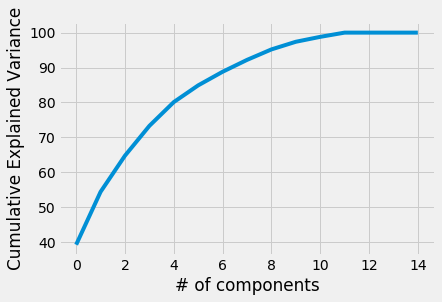

In [16]:
# PCA + Logistic regression or Decision tree
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

X_train_scaled = scale(X_train)

#classifier = linear_model.LogisticRegression()
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', classifier)])
pca.fit(X_train_scaled)

#X_proj = pca.transform(X_train_scaled)

#The amount of variance that each component explains
var = pca.explained_variance_ratio_

#Cumulative explained variance
varcum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(varcum)
plt.axis('tight')
plt.xlabel('# of components')
plt.ylabel('Cumulative Explained Variance')

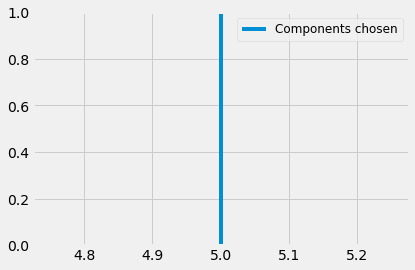

In [17]:
nComp = [5, 6, 7, 8, 9, 10, 11, 12]

estimator = GridSearchCV(pipe,dict(pca__n_components=nComp))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,linestyle='-', label='Components chosen')
plt.legend(prop=dict(size=12))
plt.show()